In [1]:
import math

import torch.nn as nn
import torch.functional as F
import torch
import pandas as pd
import numpy as np
import helpers.util as my_utils

In [2]:
device = my_utils.torch_get_device()
print(device)

Cuda device available.. Using Cuda as primary device
cuda


In [3]:
embedding_dim = 64
num_heads = 4

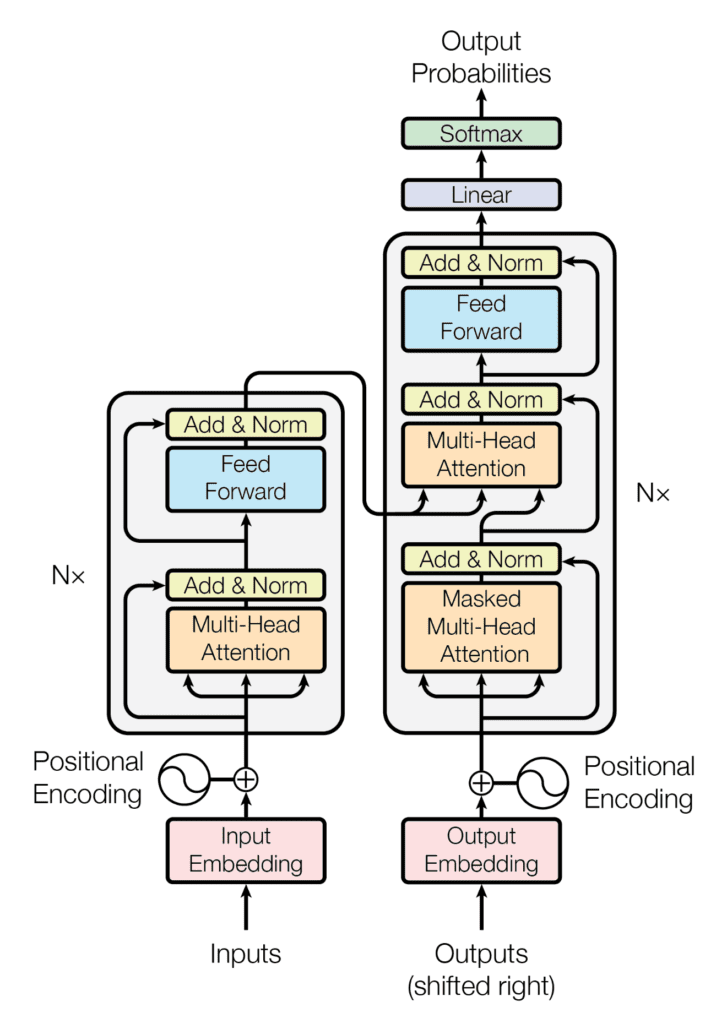

In [4]:
from IPython.display import display
from PIL import Image


path="resources/transfomer.jpeg"
display(Image.open(path))

## Steps

1. Positional encoding to give context about the position in sequence, we will be making it learnable instead of relying of sine waves
2. Attention: Consists of Query, Key and Value

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_sequence_length):
        super(PositionalEncoding, self).__init__()
        # initialize a matrix and make it as a parameter of model thus learnable by using nn.parameter
        self.positional_encoding = nn.Parameter(torch.randn(max_sequence_length, embed_dim))
        
    def forward(self, idx):
        assert idx < self.max_sequence_length
        return self.positional_encoding[idx]

In [6]:
class Attention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.query_layer = nn.Linear(embedding_dim, embedding_dim, bias = False)
        self.key_layer = nn.Linear(embedding_dim, embedding_dim, bias = False)
        self.value_layer = nn.Linear(embedding_dim, embedding_dim, bias = False)
        
        self.output_layer = nn.Linear(embedding_dim, embedding_dim)
        
    def transform_into_multi_heads(self, tensor):
        ## in:- batch_size, sequence, embed_dim
        assert tensor.size(1) % self.num_heads == 0, "Embedding dimension should be divisible by number of heads"
        tensor = tensor.view(tensor.size(0), tensor.size(1), self.num_heads, tensor.size(2)//self.num_heads)
        return tensor.transpose(1, 2)
    
    def combine_heads(self, tensor):
        ##in:- batch_size, num_heads, sequence, embed_dim/num_heads
        tensor = tensor.transpose(1, 2)
        return tensor.view(tensor.size(0), tensor.size(1), tensor.size(2)*tensor.size(3))
        
        
    def scaled_dot_product_attention(self, query, key, value):
        ## shape of tensor: [batch_size, num_heads, sequence_length, embed/num_heads]
        attention_weights = torch.matmul(query, key.transpose(-1, -2))/math.sqrt(query.size(-1))
        attention_weights = torch.softmax(attention_weights, dim = -1)
        dot_product_attention = torch.matmul(attention_weights, value)
        return dot_product_attention
        
        
    def forward(self, in_sequence):
        ## in_sequence shape: batch_size, sequence_length, embedding_size
        query = self.transform_into_multi_heads(self.query_layer(in_sequence))
        key = self.transform_into_multi_heads(self.key_layer(in_sequence))
        value = self.transform_into_multi_heads(self.value_layer(in_sequence))
        
        dot_product_attention = self.scaled_dot_product_attention(query, key, value)
        dot_product_attention = self.combine_heads(dot_product_attention)
        output =  self.output_layer(dot_product_attention)
        return output
        

In [7]:
model = PositionalEncoding(100, 200)

for param in model.parameters():\
    print(param)

Parameter containing:
tensor([[-0.3726, -0.8467, -1.0235,  ..., -1.4354,  0.5527,  0.3975],
        [-0.6545, -0.2768, -1.8550,  ...,  0.6955, -3.1231, -0.9889],
        [ 0.0980,  0.2439, -0.3497,  ...,  0.9814,  0.5938, -0.1568],
        ...,
        [-0.9796,  0.2128,  1.2573,  ...,  0.2985, -0.8580,  1.4547],
        [-0.8258,  0.6228, -0.0791,  ...,  0.4173, -0.0375,  1.4585],
        [ 0.1188, -0.4645, -2.5425,  ..., -0.7243, -1.0111,  0.8886]],
       requires_grad=True)
